Po pierwsze, musimy zaimportować dane. Pobierzmy sobie zatem zbiory z UCL i spójrzmy na nie (tam trzeba gdzieniegdzie zamienić klasy ze słowa na wartość liczbową). Po pobraniu pobierzmy jeden ze zbiorów (wina) do zeszytu.

In [51]:
import pandas as pd

def load_csv(filename):
    dataset = pd.read_csv(filename)
    dataset['Class'] = dataset['Class'].astype('category').cat.codes
    return dataset

filename = 'wine.csv'
dataset = load_csv(filename)
dataset.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,0


 Następnie musimy wydzielić klasę jako osobny label

In [52]:
def separate_class(dataset):
    target = dataset['Class']
    del dataset['Class']
    return dataset,target


data, target=separate_class(dataset)
data.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Możemy już przejść do zdefiniowania modelu i jego walidacji (zobacz jakie to proste!)

In [69]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

mnb = MultinomialNB()
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
mnb.fit(X_train, y_train)
predicted = mnb.predict(X_test)
print(confusion_matrix(y_test,predicted))

[[14  0  0]
 [ 2  5  1]
 [ 0  1 13]]


In [71]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

mnb = MultinomialNB()
predicted = cross_val_predict(mnb, data, target, cv=8) #tutaj można już ilość k-foldów sprawdzać
print(confusion_matrix(target,predicted))

[[52  2  5]
 [ 1 41  6]
 [ 3  8 60]]


In [4]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

gnb = GaussianNB() #inny klasyfikator
predicted = cross_val_predict(gnb, data, target, cv=8)  #tutaj można już ilość k-foldów sprawdzać
print(confusion_matrix(target,predicted))

[[57  2  0]
 [ 2 66  3]
 [ 0  0 48]]


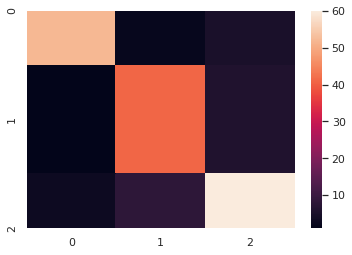

In [72]:
import seaborn as sns; sns.set(style="white", color_codes=True)
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix(target,predicted))
plt.show()

Miary poprawności działania

In [7]:
print("Accuracy: ",accuracy_score(target,predicted))
print("Precision: ",precision_score(target,predicted,average='macro'))
print("Recall: ",recall_score(target,predicted,average=None))
print("F1SCORE: ",f1_score(target,predicted,average=None))
print("Number of mislabeled points out of a total %d points : %d" % (len(data), (target != predicted).sum()))

Accuracy:  0.9606741573033708
Precision:  0.959288800265869
Recall:  [0.96610169 0.92957746 1.        ]
F1SCORE:  [0.96610169 0.94964029 0.96969697]
Number of mislabeled points out of a total 178 points : 7


Teraz zrób to samo dla zbioru glass

A na co się przydaje ta dyskretyzacja? Sprawdźmy!

In [75]:
import numpy as np
import pandas as pd

def equal_length(data, numberOfPartitions):
    data = data.to_numpy()
    datanp = np.vstack(data) #transformacja danych vertykalnie - kolumny zamieniamy z wierszami
    for i in range(datanp.shape[1]):
        indices, bins = pd.cut(datanp[:, i], numberOfPartitions, labels=False, retbins=True, duplicates='drop') #metoda pandasa do podziału zbioru na jednakową frakwencję (częstość)
        for k in range(len(indices)):
            datanp[k][i] = bins[indices[k]] #przypisanie do nowej tablicy
    return datanp

def equal_frequency(data, numberOfPartitions):
    data = data.to_numpy()
    datanp = np.vstack(data) #transformacja danych vertykalnie - kolumny zamieniamy z wierszami
    for i in range(datanp.shape[1]):
        indices, bins = pd.qcut(datanp[:, i], numberOfPartitions, labels=False, retbins=True, duplicates='drop') #metoda pandasa do podziału zbioru na jednakową frakwencję (częstość)
        for k in range(len(indices)):
            datanp[k][i] = bins[indices[k]] #przypisanie do nowej tablicy
    return datanp

def hist_division(data):
    datanp = np.vstack(data) #transformacja danych vertykalnie - kolumny zamieniamy z wierszami
    for i in range(datanp.shape[1]):
        _, bins = np.histogram(datanp[:, i], bins='fd') #podział na przedziały zależy tu od histogramu
        indices = np.digitize(datanp[:, i], bins) - 1 #Return the indices of the bins to which each value in input array belongs.
        for j in range(len(indices)):
            datanp[j][i] = bins[indices[j]] #przypisanie do nowej tablicy
    return datanp

In [77]:
datadg=equal_length(data,5)
#datadg=equal_frequency(data, 5)
#datadg=hist_division(data)

TypeError: cannot perform reduce with flexible type

Sprawdź jaka dyskretyzacja jest najlepsza dla konkretnego zbioru. Czy jest w ogóle potrzebna? Czy da się w którymś zbiorze tak manewrować parametrami, żeby osiągnąć 100%?